In [1]:
%load_ext cython
import pyrost as rst
import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from importlib import reload

pyximport.install(reload_support=True, build_in_temp=False)

(None, <pyximport.pyximport.PyxImporter at 0x7f81b10aaf90>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'barcode_profile', 'fft_python', 'gaussian_filter', 'ifft_python', 'irfft_python', 'krig_data', 'least_squares', 'make_reference', 'mse_total', 'np', 'phase_fit', 'pixel_translations', 'rfft_python', 'st', 'st_update', 'str_update', 'update_pixel_map_gs', 'upm_surface']


# ST Simulation

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, focus=1500, defocus=1000,
                           alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=40, det_dist=2e6)

globals().update(**params.export_dict())
print(params)

{'defocus': 1000.0, 'det_dist': 2000000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [10]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

58527 1508


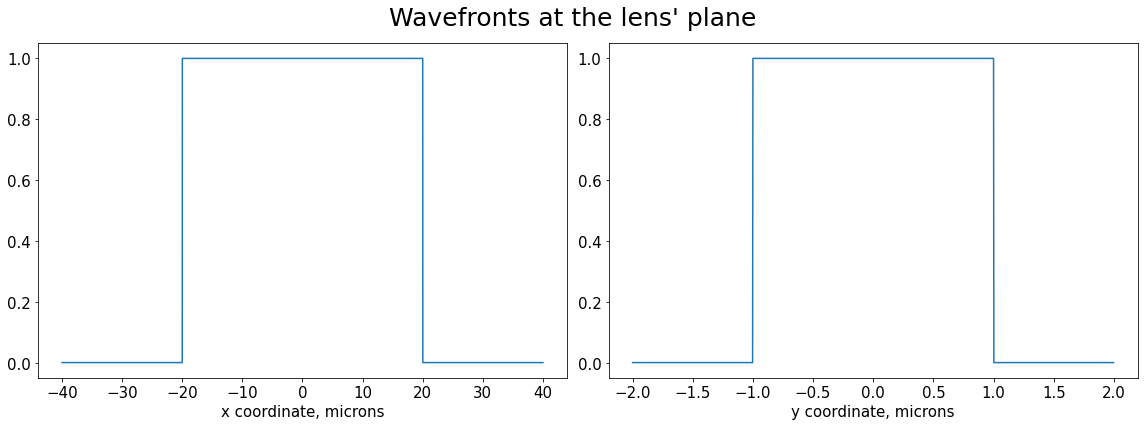

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [12]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, wl)
defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, wl)

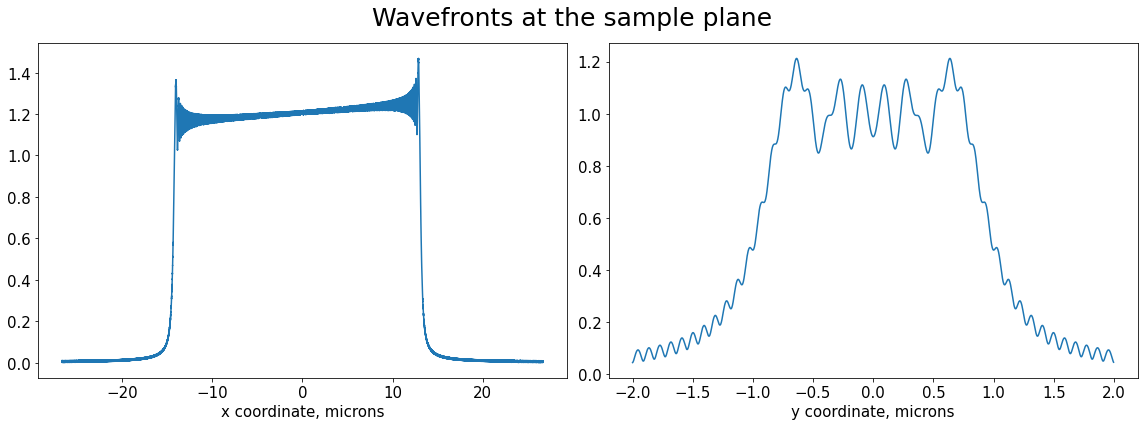

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy1 * ny_arr, np.abs(defoc_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [ ]:
x0, x1 = params.beam_span(defocus)
x1 += step_size * n_frames
bar_pos = bar_positions(x0 + offset, x1 - offset, bar_size, bar_rnd)

In [18]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
b_tr = barcode_profile(bar_pos, x_arr.ravel(), bar_atn, bar_sigma, bulk_atn).reshape(x_arr.shape)
smp_wfx = defoc_wfx * b_tr
print(b_tr.shape, smp_wfx.shape, defoc_wfx.shape)

(200, 58527) (200, 58527) (58527,)


In [19]:
dx2, dy2 = fs_size * pix_size / n_x, ss_size * pix_size / n_y
%time det_wfx = fhf_wp_scan(smp_wfx, dx1, dx2, det_dist, wl)
%time det_wfy = fhf_wp(defoc_wfy, dy1, dy2, det_dist, wl)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 14.3 s, sys: 648 ms, total: 14.9 s
Wall time: 1.35 s
CPU times: user 5.94 ms, sys: 19 µs, total: 5.96 ms
Wall time: 500 µs
(200, 58527) (200, 58527)


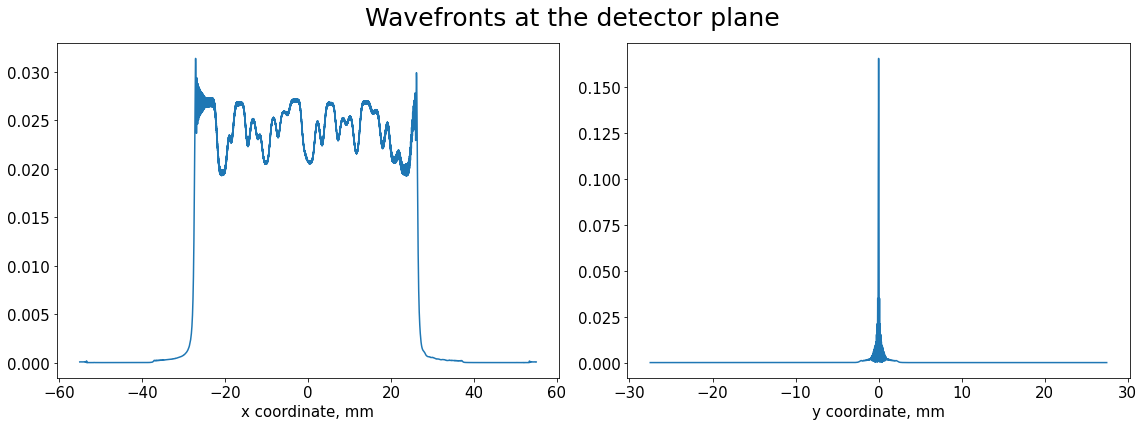

In [20]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[0]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [21]:
from scipy.signal import fftconvolve

sc_x = params.source_curve(defocus + det_dist, dx2)
sc_y = params.source_curve(defocus + det_dist, dy2)
%time det_ix = fft_convolve_scan(np.abs(det_wfx)**2, sc_x)
%time det_iy = fft_convolve(np.abs(det_wfy)**2, sc_y)
print(det_ix.shape, det_iy.shape)

CPU times: user 1.34 s, sys: 77.7 ms, total: 1.42 s
Wall time: 198 ms
CPU times: user 3.18 ms, sys: 645 µs, total: 3.83 ms
Wall time: 433 µs
(200, 58527) (1508,)


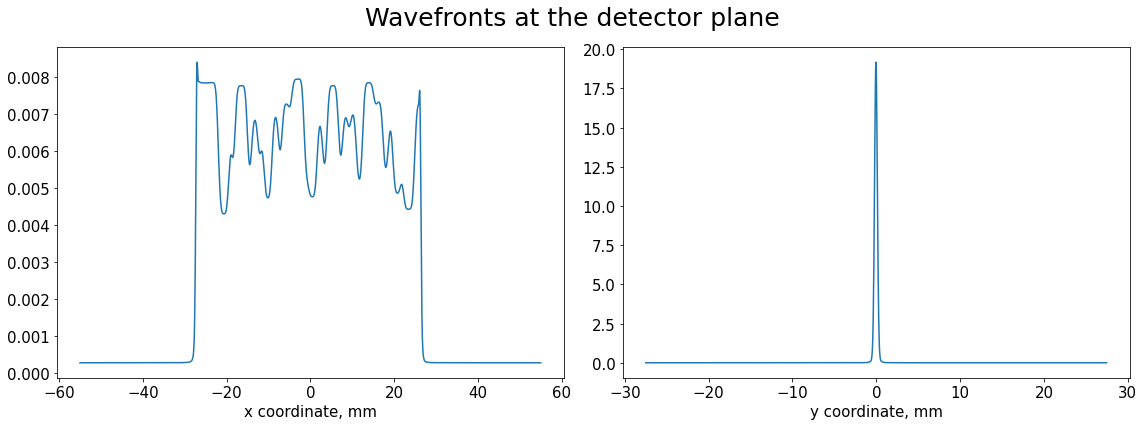

In [22]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.sqrt(p0) / ap_x * det_ix[0] * dx2)
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.sqrt(p0) / ap_y * det_iy * dy2)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [23]:
%time frames = make_frames(np.sqrt(p0) / ap_x * det_ix, np.sqrt(p0) / ap_y * det_iy, \
                               dx2, dy2, ss_size, fs_size, True)

CPU times: user 10.5 s, sys: 1.42 s, total: 12 s
Wall time: 1.06 s


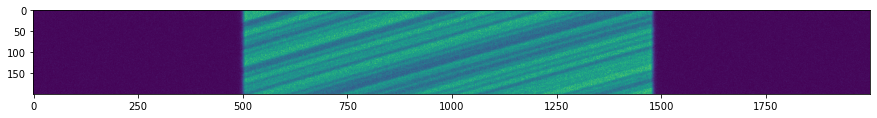

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(frames.sum(axis=1))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [3]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'barcode_profile', 'fft_python', 'gaussian_filter', 'ifft_python', 'irfft_python', 'krig_data', 'least_squares', 'make_reference', 'mse_total', 'np', 'phase_fit', 'pixel_translations', 'rfft_python', 'st', 'st_update', 'str_update', 'update_pixel_map_gs', 'upm_surface']


In [20]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, offset=2.0, defocus=20, alpha=0.03,
                           ab_cnt=0.7)
params.step_size = max(2 * params.ap_x / params.focus * params.defocus,
                       5 * params.bar_size) / params.n_frames
params.offset = 0.7 * params.ap_x / params.focus * params.defocus

st_conv = st_sim.converter()
sim_obj = st_sim.STSim(params)
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

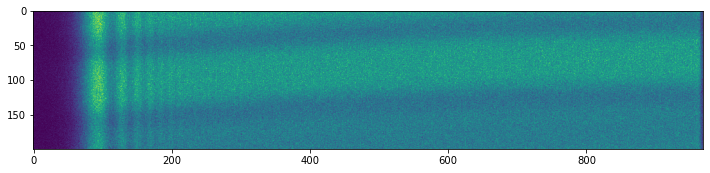

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [6]:
res = dev.st_update(I_n=data.get('data'), dij=data.get('translations'),
                    basis=data.get('basis_vectors'), x_ps=data.x_pixel_size,
                    y_ps=data.y_pixel_size, z=data.distance,
                    df=data.defocus_fs, sw_ss=0, sw_fs=100, ls=.1, n_iter=5, filt=.2)

In [13]:
st_obj = data.get_st()
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=10, ls_pm=2.5, verbose=True, n_iter=30, f_tol=-1)

Initial MSE = 0.138479, Initial ls_ri = 10.00
Iteration No. 1: Total MSE = 0.115216, ls_ri = 15.65
Iteration No. 2: Total MSE = 0.098817, ls_ri = 21.05
Iteration No. 3: Total MSE = 0.085845, ls_ri = 26.22
Iteration No. 4: Total MSE = 0.076339, ls_ri = 30.44
Iteration No. 5: Total MSE = 0.070353, ls_ri = 33.17
Iteration No. 6: Total MSE = 0.069995, ls_ri = 33.43
Iteration No. 7: Total MSE = 0.071437, ls_ri = 32.95
Iteration No. 8: Total MSE = 0.070317, ls_ri = 33.58
Iteration No. 9: Total MSE = 0.068131, ls_ri = 34.92
Iteration No. 10: Total MSE = 0.065738, ls_ri = 36.48
Iteration No. 11: Total MSE = 0.063715, ls_ri = 37.85
Iteration No. 12: Total MSE = 0.062238, ls_ri = 38.83
Iteration No. 13: Total MSE = 0.061047, ls_ri = 39.62
Iteration No. 14: Total MSE = 0.060281, ls_ri = 40.17
Iteration No. 15: Total MSE = 0.059755, ls_ri = 40.54
Iteration No. 16: Total MSE = 0.059677, ls_ri = 40.62
Iteration No. 17: Total MSE = 0.059953, ls_ri = 40.50
Iteration No. 18: Total MSE = 0.060180, ls_ri

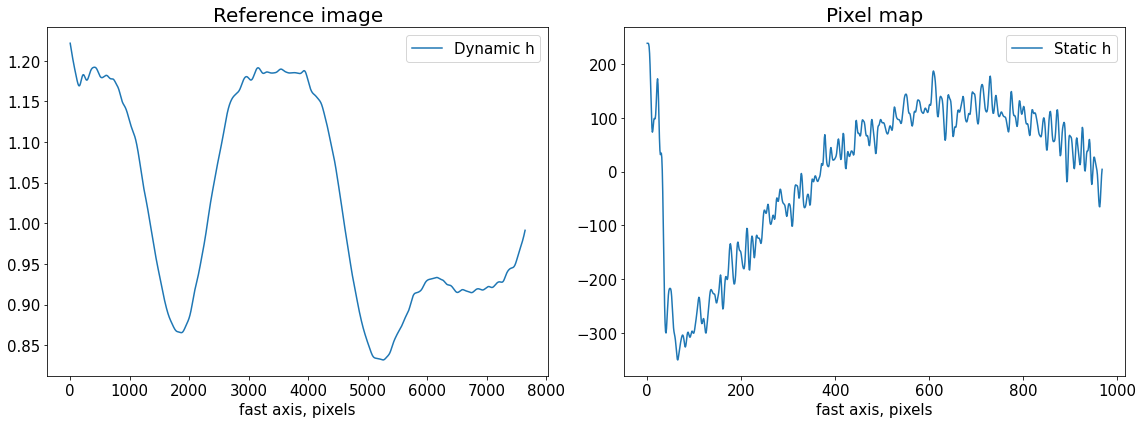

In [14]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
loader = rst.loader()
data = loader.load('results/exp/diatom.cxi', roi=(70, 420, 50, 455), good_frames=np.arange(1, 121))
data = data.update_mask(method='perc-bad', pmin=0.05, pmax=99.998)

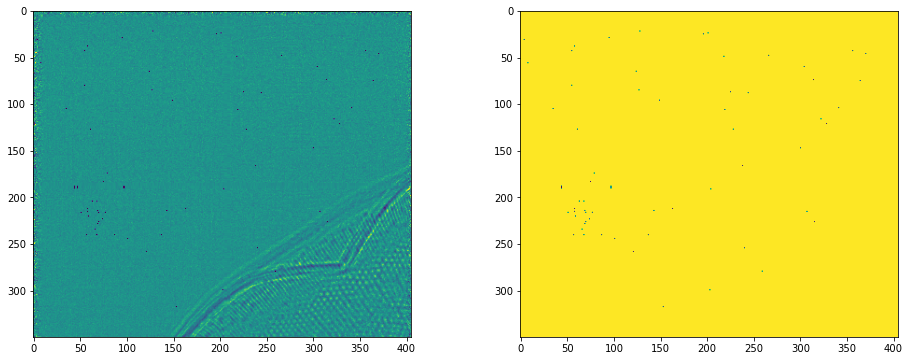

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(np.where(data.get('mask')[0],
                        data.get('data')[0] / data.get('whitefield'),
                        0), vmin=0.5, vmax=1.5)
axes[1].imshow(data.get('mask')[0], vmin=0, vmax=1)
plt.show()

In [12]:
st_obj = data.get_st()
st_obj = st_obj.update_reference(ls_ri=1.1, sw_ss=0, sw_fs=0)

In [14]:
st_obj = data.get_st()
st_rgd = st_obj.iter_update_gd(ls_ri=1.1, ls_pm=1.5, sw_fs=2, sw_ss=2, n_iter=4,
                               verbose=True, learning_rate=0.1)

Initial MSE = 0.874955, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.662130, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.487592, ls_ri = 1.47
Iteration No. 3: Total MSE = 0.446233, ls_ri = 1.52
Iteration No. 4: Total MSE = 0.429475, ls_ri = 1.55


In [16]:
data.data.shape, data.mask.shape

((121, 516, 1556), (121, 516, 1556))

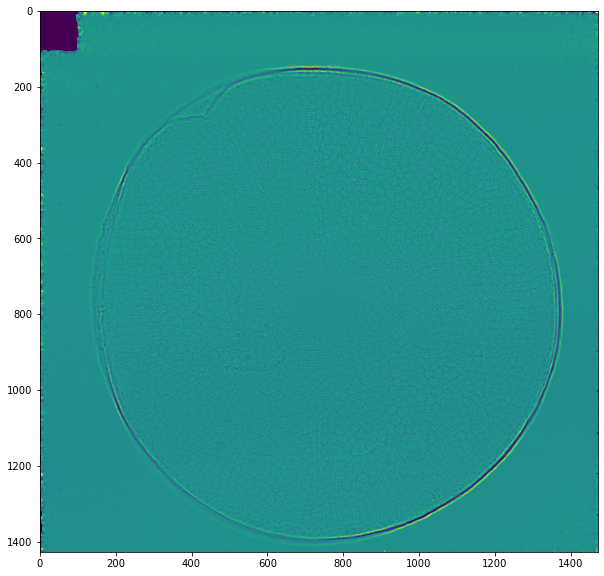

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(st_obj.reference_image, vmin=0.7, vmax=1.3)
ax.imshow(st_rgd.reference_image, vmin=0.7, vmax=1.3)
plt.show()

# Datasets simulation

In [3]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, offset=2.0, defocus=400, alpha=0.05,
                           ab_cnt=0.7)

globals().update(**params.export_dict())
print(params)

{'defocus': 400.0, 'det_dist': 2000000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2, 'fs_size': 2000, 'pix_size': 55.0, '...': '...'}


In [19]:
st_conv = st_sim.converter()
defoci = np.geomspace(40, 1000, 5)
sim_dict, data_dict = {}, {}

for defocus in defoci:
    key = int(defocus)
    params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                               bulk_atn=0.15, bar_rnd=0.7, p0=5e4, th_s=2.5e-4,
                               n_frames=200, defocus=defocus, alpha=0.03, ab_cnt=0.7)
    params.step_size = max(2 * params.ap_x / params.focus * params.defocus,
                           5 * params.bar_size) / params.n_frames
    params.offset = 0.7 * params.ap_x / params.focus * params.defocus
    sim_dict[key] = st_sim.STSim(params=params)
    data_dict[key] = st_conv.export_data(sim_dict[key].ptychograph(), sim_dict[key])

    st_obj = data_dict[key].get_st()
    st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=20, ls_pm=2.5, return_extra=False)
    data_dict[key] = data_dict[key].update_phase(st_res)
    
print([(key, data.fit_phase()['alpha']) for key, data in data_dict.items()])

[(40, -0.024653393240160783), (89, -0.03139072248107814), (200, -0.023946268809463423), (447, -0.029978493588203352), (1000, -0.027917207849566368)]


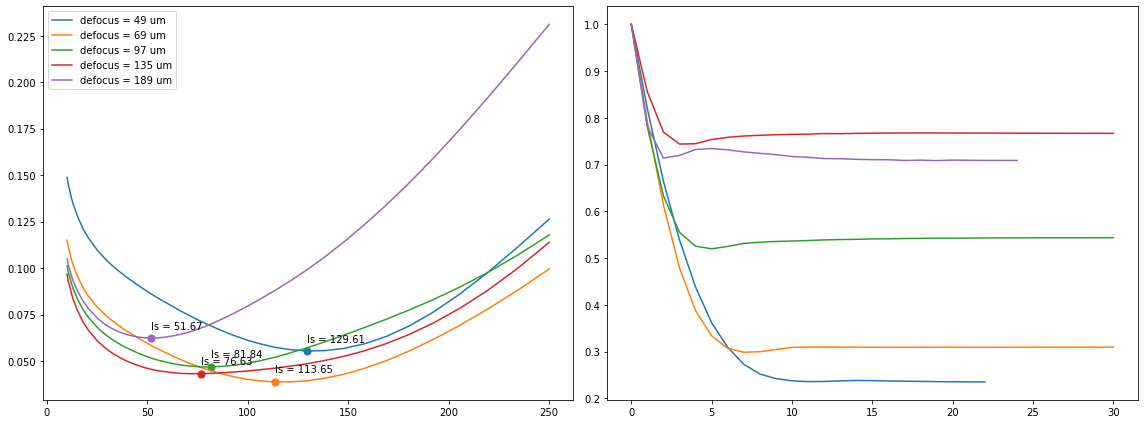

In [36]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for key, color in zip(sorted(data_dict)[:5], mcolors.TABLEAU_COLORS):
    axes[0].plot(lss_ri, mse_ind[key], label='defocus = {:d} um'.format(key))
    axes[0].scatter(lss_ri[np.argmin(mse_ind[key])], np.min(mse_ind[key]), s=50)
    axes[0].text(lss_ri[np.argmin(mse_ind[key])] + 0.01, np.min(mse_ind[key]) + 0.005,
            s='ls = {:.2f}'.format(lss_ri[np.argmin(mse_ind[key])]))
    axes[1].plot(err_dict[key] / err_dict[key][0], linestyle='solid', color=color)
axes[0].legend()
plt.tight_layout()
plt.show()
# plt.savefig('figures/dynamic_update.pdf')

In [17]:
st_conv = st_sim.converter()
out_path = 'results/defocus/defocus_alpha_30/defocus_{:d}um'
for key in data_dict:
    st_conv.save_sim(data_dict[key].data, sim_dict[key], out_path.format(key))
    with h5py.File(os.path.join(out_path.format(key), 'data.cxi'), 'r+') as cxi_file:
        data_dict[key].write_cxi(cxi_file)

In [22]:
print(sorted(data_dict))

[40, 89, 200, 447, 1000]


In [23]:
key = 1000
data = data_dict[key]

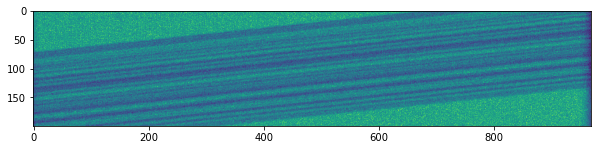

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

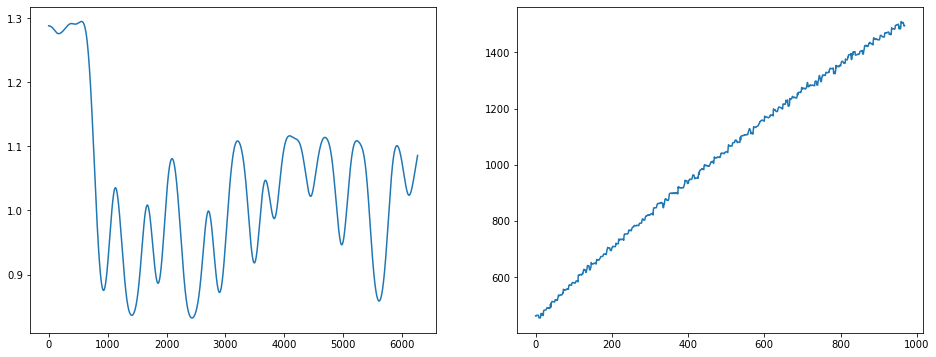

In [10]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[1].plot(st_res.pixel_map[1, 0])
plt.show()

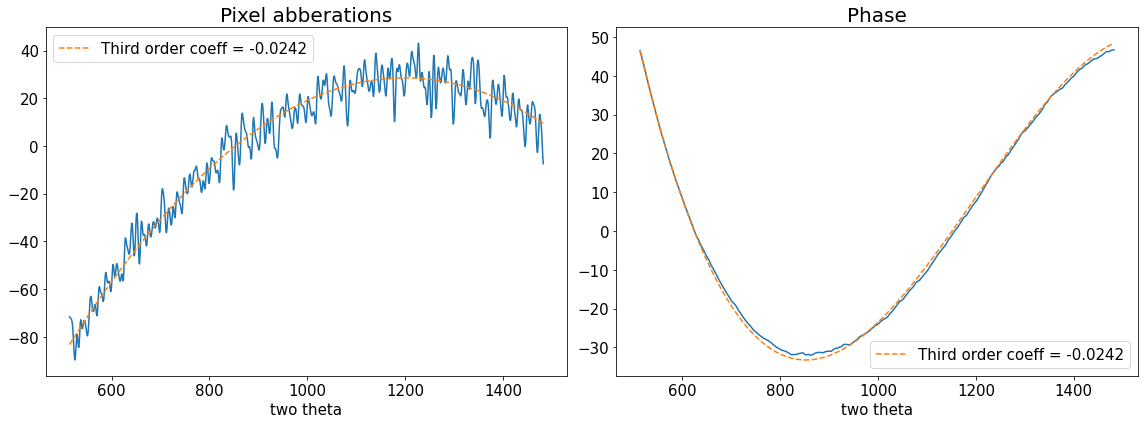

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit = fit_obj.fit()
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experimental results

In [3]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2557

loader = rst.loader()
data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])

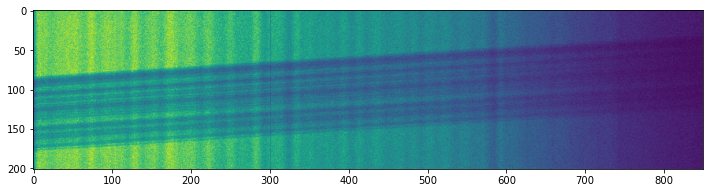

In [4]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

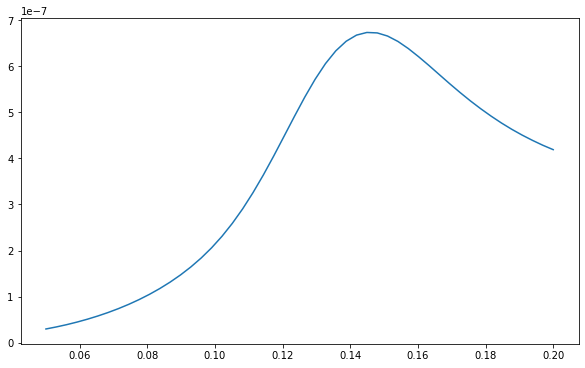

In [201]:
defoci = np.linspace(5e-5, 2e-4, 50)
ds_scan = data.defocus_sweep(defoci, ls_ri=30, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [302]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=15, ls_pm=2.5, sw_fs=6, n_iter=20, verbose=True)

Initial MSE = 0.030984, Initial ls_ri = 15.00
Iteration No. 1: Total MSE = 0.025798, ls_ri = 18.82
Iteration No. 2: Total MSE = 0.023825, ls_ri = 20.40
Iteration No. 3: Total MSE = 0.023105, ls_ri = 21.01
Iteration No. 4: Total MSE = 0.022989, ls_ri = 21.12
Iteration No. 5: Total MSE = 0.023005, ls_ri = 21.12


In [303]:
data = data.update_phase(st_rgd)
fit_obj = data.get_fit()

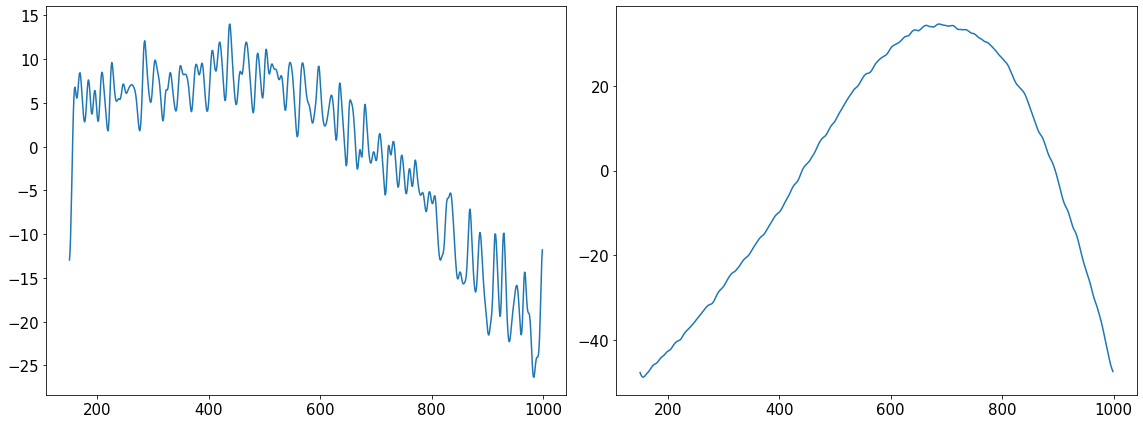

In [304]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.get('pixels'), fit_obj.get('pixel_abberations'))
axes[1].plot(fit_obj.get('pixels'), fit_obj.get('phase'))
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

In [9]:
data_path = 'results/exp/scan_81763.cxi'
loader = rst.loader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', percentile=99.995)

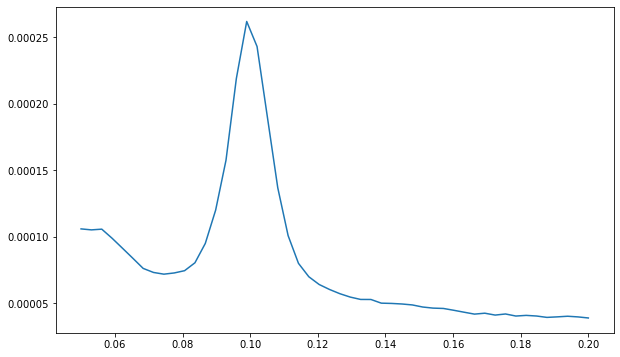

In [198]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls = data_nsls.defocus_sweep(df_nsls, ls_ri=1.1, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [328]:
data.wavelength

array(7.09291753e-11)

In [295]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, sw_fs=3, sw_ss=3, n_iter=20, verbose=True,
                                         learning_rate=0.1)

data_nsls = data_nsls.update_phase(st_rgd_nsls)

Initial MSE = 0.766755, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.553753, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.445012, ls_ri = 1.41
Iteration No. 3: Total MSE = 0.389979, ls_ri = 1.49
Iteration No. 4: Total MSE = 0.433399, ls_ri = 1.47


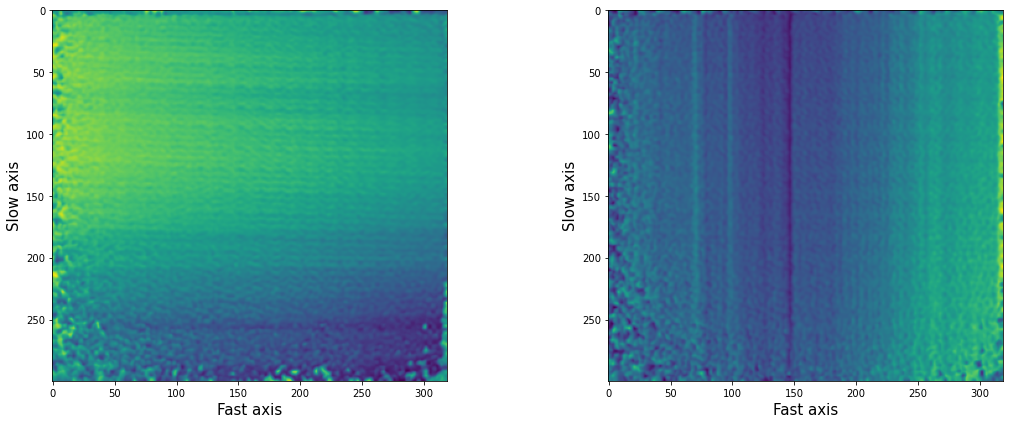

In [327]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

In [305]:
thetas = np.arange(10, 230) * data_nsls.y_pixel_size / data_nsls.distance
dev = np.interp(thetas, (fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
                   fit_obj.pixel_abberations * data.defocus_fs * data.x_pixel_size / data.distance)

In [312]:
pix_shift = 5

# dev_ss = np.mean((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, 100:], axis=1, keepdims=True)
dev_ss = (st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, [280]].T
dev_fs = np.zeros(dev_ss.shape, dtype=np.float64)
d_ab = (dev - dev_ss[10 + pix_shift:230 + pix_shift, 0] * \
        data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance).mean()
dev_ss += d_ab / (data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance)

phase = ct_integrate(data_nsls.y_pixel_size**2 * dev_ss * data_nsls.defocus_ss / data_nsls.wavelength,
                     data_nsls.x_pixel_size**2 * dev_fs * data_nsls.defocus_fs / data_nsls.wavelength) \
        * 2 * np.pi / data_nsls.distance**2
fit_obj_nsls = rst.AbberationsFit(defocus=data_nsls.defocus_ss, distance=data_nsls.distance,
                                  phase=phase[:, 0], pixels=np.arange(0, phase.size) - pix_shift,
                                  pixel_abberations=dev_ss[:, 0], pixel_size=data_nsls.y_pixel_size,
                                  roi=(0, phase.size), wavelength=data_nsls.wavelength)
dev_ss.shape

(300, 1)

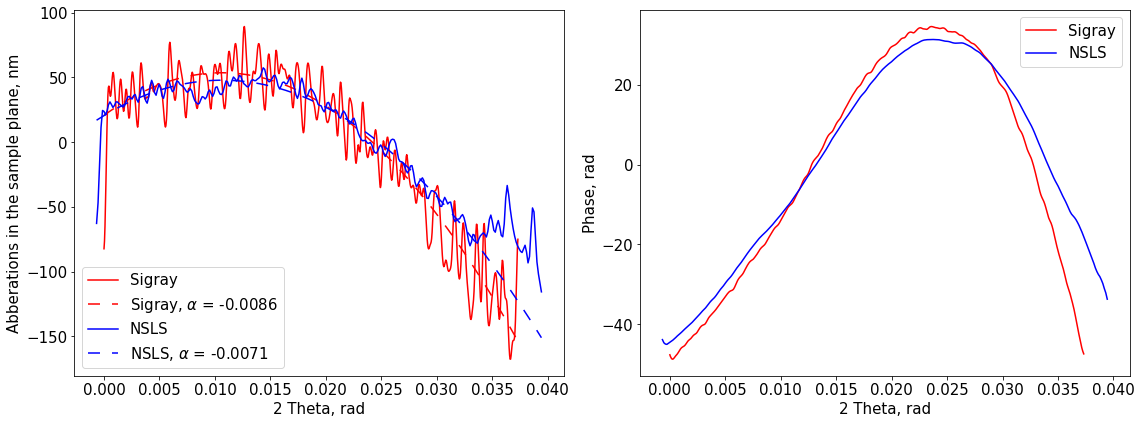

In [323]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit_nsls = fit_obj_nsls.crop_data([10, 240]).fit()
fit = fit_obj.crop_data([10, 650]).fit(loss='linear')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_abberations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('Abberations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].set_ylabel('Phase, rad', fontsize=15)
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.pixel_abberations * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label=r'NSLS, $\alpha$ = ' + '{:.4f}'.format(fit_nsls['alpha']),
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.phase, label='NSLS', c='b')
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()